# EPSIE
#### Collin Capano

[Epsie](https://github.com/cdcapano/epsie) is a python package for doing MCMC sampling. It parallelizes sampling over multiple chains. Unlike `emcee`, no communication is done between chains. It is not specific to gravitational wave problems, which is why it lives outside of PyCBC. Work is currently on-going to add support for it to PyCBC Inference (you can track the progress [here](https://github.com/gwastro/pycbc/pull/2697)). 

Epsie is very much a work in progress. Currently, it has:
 * a Metropolis-Hastings;
 * a parallel tempered sampler;
 * normal and adaptive normal jump proposals.

In this notebook we will setup the PT sampler to sample a 2D Gaussian distribution with mean $\bar{x} = 2, \bar{y} = 5$ and variance $\sigma_x^2 = 1$, $\sigma_y^2 = 2$; $\sigma^2_{xy} = \sigma^2_{yx} = 0$, using a prior that is uniform over $x, y \in [-20, 20)$.

We will sample the space with 12 chains, each of which has 3 tempertures. We will use Python's multiprocessing to parallelize running over 4 cores. We then demonstrate how to extract results, as well as how to resume a sampler from a saved state.

### Prerequisites

In [2]:
import sys
!{sys.executable} -m pip install epsie matplotlib --no-cache-dir

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
     |████████████████████████████████| 61kB 6.5MB/s eta 0:00:01
     |████████████████████████████████| 14.0MB 669kB/s eta 0:00:011
     |████████████████████████████████| 27.4MB 17.3MB/s eta 0:00:01
     |████████████████████████████████| 1.9MB 18.8MB/s eta 0:00:01
     |████████████████████████████████| 13.9MB 38.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 21.0MB/s eta 0:00:01
     |████████████████████████████████| 71kB 44.3MB/s eta 0:00:01
     |████████████████████████████████| 512kB 288kB/s eta 0:00:01
     |████████████████████████████████| 2.8MB 7.1MB/s eta 0:00:01


In [3]:
%matplotlib notebook
from __future__ import print_function
from matplotlib import pyplot
import numpy
import randomgen

import epsie
from epsie import make_betas_ladder
from epsie.samplers import ParallelTemperedSampler
import multiprocessing

## Create the model to sample

***Note:*** Below we create a class with several functions to draw samples from the prior and to evaluate the log posterior. This isn't strictly necessary. The only thing the Sampler really requires is a function that it can pass keyword arguments to and get back a tuple of (log likelihood, log prior). However, setting things up as a class will make it convenient to, e.g., draw random samples from the prior for the starting positiions, as well as plot the model later on.

In [4]:
from scipy import stats
class Model(object):
    def __init__(self):
        # we'll use a 2D Gaussian for the likelihood distribution
        self.params = ['x', 'y']
        self.mean = [2., 5.]
        self.cov = [[1., 0.], [0., 2.]]
        self.likelihood_dist = stats.multivariate_normal(mean=self.mean,
                                                         cov=self.cov)

        # we'll just use a uniform prior
        self.prior_bounds = {'x': (-20., 20.),
                             'y': (-20., 20.)}
        xmin = self.prior_bounds['x'][0]
        dx = self.prior_bounds['x'][1] - xmin
        ymin = self.prior_bounds['y'][0]
        dy = self.prior_bounds['y'][1] - ymin
        self.prior_dist = {'x': stats.uniform(xmin, dx),
                           'y': stats.uniform(ymin, dy)}

    def prior_rvs(self, size=None, shape=None):
        return {p: self.prior_dist[p].rvs(size=size).reshape(shape)
                for p in self.params}
    
    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])
    
    def loglikelihood(self, **kwargs):
        return self.likelihood_dist.logpdf([kwargs[p] for p in self.params])
    
    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp

In [5]:
model = Model()

## Setup and run the sampler

Create a pool of 4 parallel processes, then initialize the sampler using the model we created above.

In [4]:
nchains = 12
ntemps = 3
nprocs = 4
pool = multiprocessing.Pool(nprocs)

betas = make_betas_ladder(ntemps, 1e5)
sampler = ParallelTemperedSampler(model.params, model, nchains, betas=betas, pool=pool)

Now set the starting positions of the chains by drawing random variates from the model's prior.

In [5]:
sampler.start_position = model.prior_rvs(size=nchains*ntemps, shape=(nchains, ntemps))

### Let's run it!

This will evolve each chain in the collection by 250 steps. This is parallelized over the pool of processes.

In [6]:
sampler.run(250)

## Extract results

We can get the history of all of the chains using the `.positions` attribute. This will return a numpy structured array in which the fields are the parameters names (in this case, `'x'` and `'y'`), and with shape `ntemps x nchains x niterations`:

In [7]:
positions = sampler.positions
print('sampler.positions: {}'.format(type(positions)))
print('with fields: {}'.format(positions.dtype.names))
print('and shape:', positions.shape)

sampler.positions: <type 'numpy.ndarray'>
with fields: ('x', 'y')
and shape: (3, 12, 250)


This (or any structured array returned by epsie) can be turned into a dictionary of arrays, where the keys are the parameter names, using `epsie.array2dict`:

In [8]:
positions = epsie.array2dict(sampler.positions)
print('sampler.positions: {} with keys/values:'.format(type(positions)))
for param in sorted(positions):
    print('"{}": {} with shape {}'.format(param, type(positions[param]), positions[param].shape))

sampler.positions: <type 'dict'> with keys/values:
"x": <type 'numpy.ndarray'> with shape (3, 12, 250)
"y": <type 'numpy.ndarray'> with shape (3, 12, 250)


We can also access the history of log likelihoods and log priors using `sampler.stats`, as well as the acceptance ratios and which jumps were accepted with `sampler.acceptance`:

In [9]:
stats = sampler.stats
print('sampler.stats: {}'.format(type(positions)))
print('with fields: {}'.format(stats.dtype.names))
print('and shape:', stats.shape)

sampler.stats: <type 'dict'>
with fields: ('logl', 'logp')
and shape: (3, 12, 250)


In [10]:
acceptance = sampler.acceptance
print('sampler.acceptance: {}'.format(type(acceptance)))
print('with fields: {}'.format(acceptance.dtype.names))
print('and shape:', acceptance.shape)

sampler.acceptance: <type 'numpy.ndarray'>
with fields: ('acceptance_ratio', 'accepted')
and shape: (3, 12, 250)


## Resume from a state

The sampler can be checkpointed by getting its current state with `sampler.state`. To demonstrate this, we'll get the current state of the sampler, then run it for another set of iterations. We'll then create a new sampler, and set it's state to the state we obtained from first sampler. Running the same sampler for the same number of iterations should produce the same results.

In [13]:
# get the current state
state = sampler.state

In [14]:
# now advance the sampler for another 250 iterations
sampler.run(250)

In [15]:
# create a new sampler, but set it's state to what the original sampler's was after the first 250 iterations
sampler2 = ParallelTemperedSampler(model.params, model, nchains, betas=betas, pool=pool)
sampler2.set_state(state)

In [16]:
# now advance the new sampler for 250 iterations
# note that we don't have to run set_start first, since the starting positions have been set by set_start
sampler2.run(250)

In [17]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,:,-1] == sampler2.acceptance['acceptance_ratio'][:,:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,:,-1] == sampler2.acceptance['accepted'][:,:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Clearing memory and continuing

The history of results in memory can be cleared using `.clear()`. Running the sampler after a clear yields the same results as if no clear had been done. This is useful for keeping memory usage down: you can dump results to a file after some number of iterations, clear, then continue.

To demonstrate this, we'll clear `sampler2`, then run both `sampler` and `sampler2` for another 250 iterations. We'll then compare the current results; they should be the same.

In [18]:
sampler2.clear()

In [19]:
sampler.run(250)
sampler2.run(250)

In [20]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,:,-1] == sampler2.acceptance['acceptance_ratio'][:,:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,:,-1] == sampler2.acceptance['accepted'][:,:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Create an animation of the results

To visualize the results, we'll create an animation showing how the chains evolved. We'll do this by plotting one point for each chain, with each frame in the animation representing a single iteration.

In [ ]:
from matplotlib import animation

In [ ]:
# Prepare an array to create a density map showing the shape of the model posterior
npts = 100
xmean, ymean = model.likelihood_dist.mean
xsig = model.likelihood_dist.cov[0,0]**0.5
ysig = model.likelihood_dist.cov[1,1]**0.5
X, Y = numpy.mgrid[xmean-3*xsig:xmean+3*xsig:complex(0, npts),
                   ymean-3*ysig:ymean+3*ysig:complex(0, npts)]
Z = numpy.zeros(X.shape)
for ii in range(Z.shape[0]):
    for jj in range(Z.shape[1]):
        logl, logp = model(x=X[ii,jj], y=Y[ii,jj])
        Z[ii, jj] = numpy.exp(logl+logp)

In [ ]:
# we'll just animate the first 200 iterations; change this to
# nframes = xdata.shape[1] if you want to see all iterations
nframes = 200

In [ ]:
fig, ax = pyplot.subplots()

positions = sampler.positions[0,...]
xdata = positions['x']
ydata = positions['y']

# Plot contours showing the shape of the true posterior density
#ax.contour(X, Y, Z, 2, colors='k', linewidths=1, linestyles='dashed', zorder=-2)
ax.imshow(numpy.rot90(Z), extent=[X.min(), X.max(), Y.min(), Y.max()],
          aspect='auto', cmap='binary', zorder=-3)

# Put an x at the maximum posterior point
ax.scatter(model.mean[0], model.mean[1], marker='x', color='w', s=10, zorder=-2)
ax.set_xlabel('x')
ax.set_ylabel('y')
# create the scatter points
ptsize = 60

# we'll include the last bufferlen number of steps a chain visited, having the size and transparency
# exponentially damped with each new frame
bufferlen = 16
alphas = numpy.exp(-4*(numpy.arange(bufferlen))/float(bufferlen))
sizes = ptsize * alphas
#colors = numpy.array(['C{}'.format(ii) for ii in range(nchains)])
colors = numpy.arange(nchains)
plts = [ax.scatter(xdata[:, bufferlen-ii-1], ydata[:, bufferlen-ii-1], c=colors, s=sizes[ii],
                   edgecolors='w', linewidths=0.5,
                   alpha=alphas[ii], zorder=bufferlen-ii, marker='s' if ii==0 else 'o', cmap='jet')
        for ii in range(bufferlen)]
# put a + showing the average of the chain positions at the current iteration
meanplt = ax.scatter(xdata[:,0].mean(), ydata[:,0].mean(), marker='P', c='w', edgecolors='k', linewidths=0.5,
                     zorder=bufferlen+1)

# add some text giving the iteration
itertxt = 'Iteration {}'
txt = ax.annotate(itertxt.format(1), (0.03, 0.94), xycoords='axes fraction')

def animate(ii):
    txt.set_text(itertxt.format(ii+1))
    for jj,plt in enumerate(plts):
        plt.set_offsets(numpy.array([xdata[:, max(ii-jj, 0)], ydata[:, max(ii-jj, 0)]]).T)
    meanplt.set_offsets([xdata[:,ii].mean(), ydata[:,ii].mean()])
    # zoom in as it narrows on the result
    istart = max(ii-bufferlen, 0)
    # smooth it out a bit
    xmin = numpy.array([xdata[:, max(istart-kk, 0):].min() for kk in range(50)]).mean()
    xmax = numpy.array([xdata[:, max(istart-kk, 0):].max() for kk in range(50)]).mean()
    ymin = numpy.array([ydata[:, max(istart-kk, 0):].min() for kk in range(50)]).mean()
    ymax = numpy.array([ydata[:, max(istart-kk, 0):].max() for kk in range(50)]).mean()
    ax.set_xlim((1.1 if xmin < 1 else 0.9)*xmin, (0.9 if xmax < 1 else 1.1)*xmax)
    ax.set_ylim((1.1 if ymin < 1 else 0.9)*ymin, (0.9 if ymax < 1 else 1.1)*ymax)


ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=160, blit=True)

Save the animation:

In [ ]:
ani.save('pt_chain_animation.mp4')

The result:

In [ ]:
%%HTML
<video width="640" height="480" controls>
  <source src="pt_chain_animation.mp4" type="video/mp4">
</video>

## Plot acceptance rates

We'll plot the acceptance rate for each chain, which we define here as the number of times a proposal was accepted divided by the total number of iterations.

In [21]:
acceptance = sampler.acceptance
arate = acceptance['accepted'].sum(axis=2)/float(acceptance.shape[-1])
aratio = acceptance['acceptance_ratio']
# limit to 1
aratio[aratio > 1] = 1.
aratio = aratio.mean(axis=2)

<IPython.core.display.Javascript object>


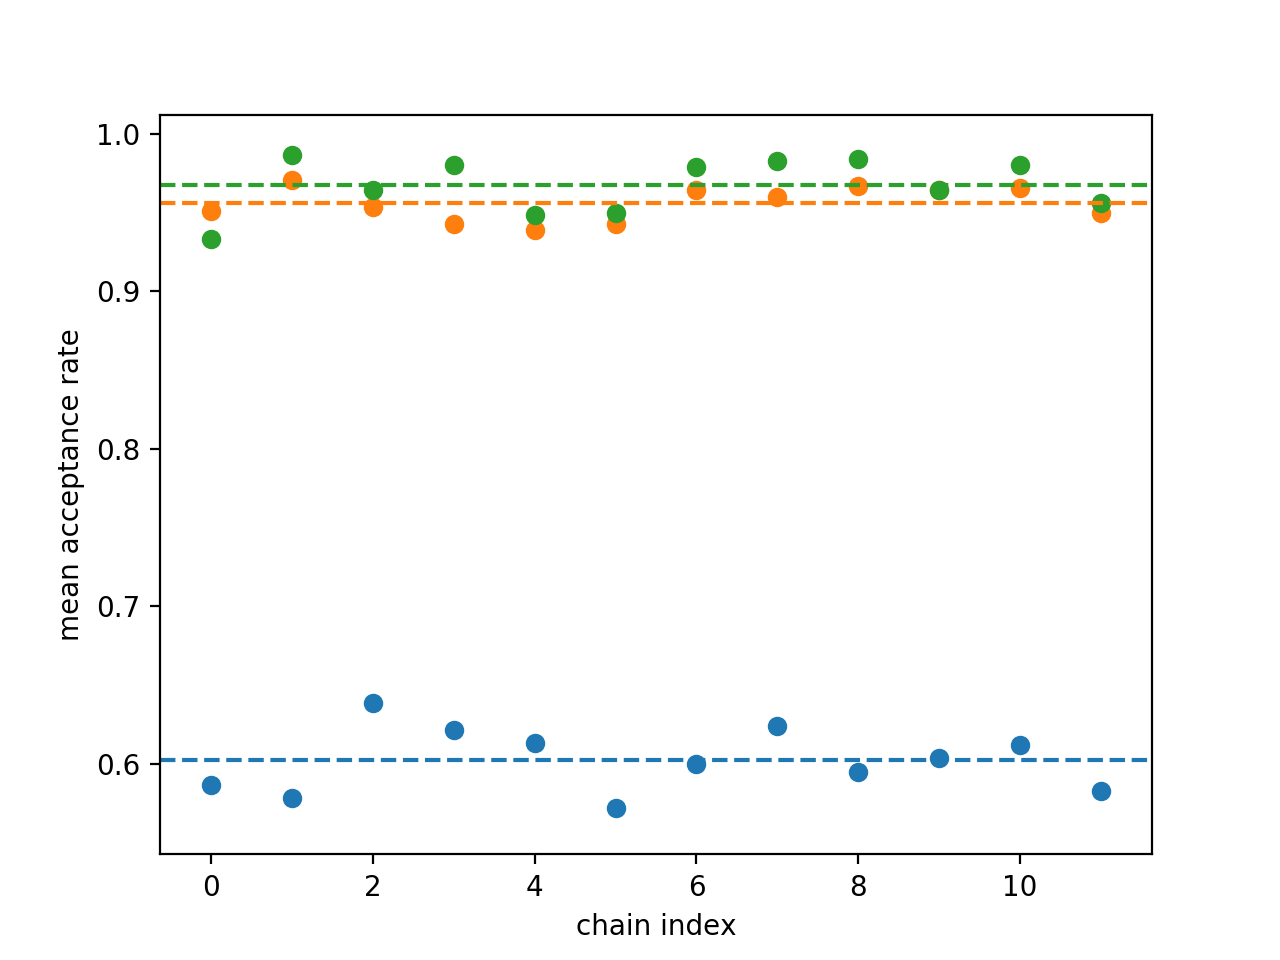

In [22]:
# plot
fig, ax = pyplot.subplots()
for tk in range(ntemps):
    ax.scatter(range(nchains), arate[tk,:], label='temp {}'.format(tk))
    ax.axhline(arate[tk,:].mean(), color='C{}'.format(tk), linestyle='--')
ax.set_ylabel('mean acceptance rate')
ax.set_xlabel('chain index')
fig.show()

In [23]:
print("Average acceptance rate over all chains:", arate.mean(axis=1))

Average acceptance rate over all chains: [0.60233333 0.95566667 0.96722222]


Let's also plot the average acceptance ratio. This should be approximately the same as the acceptance rate.

<IPython.core.display.Javascript object>


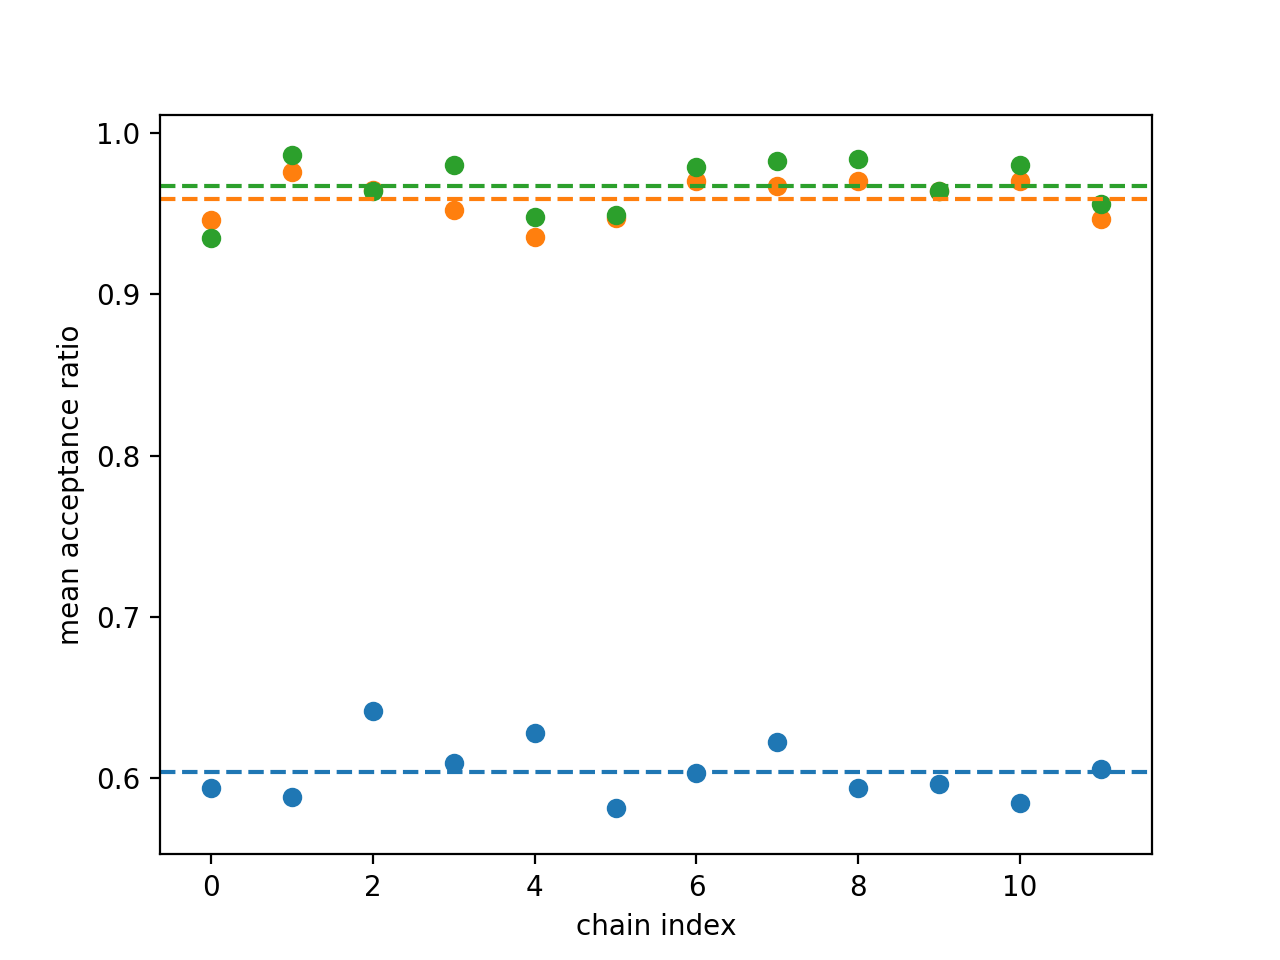

In [24]:
# plot
fig, ax = pyplot.subplots()
for tk in range(ntemps):
    ax.scatter(range(nchains), aratio[tk,:], label='temp {}'.format(tk))
    ax.axhline(aratio[tk,:].mean(), color='C{}'.format(tk), linestyle='--')
ax.set_ylabel('mean acceptance ratio')
ax.set_xlabel('chain index')
fig.show()

In [25]:
print("Average acceptance ratio over all chains:", aratio.mean(axis=1))

Average acceptance ratio over all chains: [0.60396283 0.9591926  0.96728552]


## Adaptive normal proposal

The ideal acceptance rate is ~0.23. We see here that we have a larger rate. This is not too surprising, since we only used a `Normal` proposal distribution with a variance of 1, whereas the sampled distribution was had variance of in the y parameter of 2.

To get a rate closer to 0.23, we can use an `AdaptiveNormal` proposal distribution.

In [6]:
from epsie.proposals import AdaptiveNormal

In [7]:
adaptation_duration = 100
prior_widths = {p: abs(bnds[1] - bnds[0]) for p, bnds in model.prior_bounds.items()}
adaptive_proposal = AdaptiveNormal(model.params, prior_widths, adaptation_duration=adaptation_duration)

This can be passed to the `ParallelTemperedSampler` via the `proposals` argument; specifically:
```
proposals={('x', 'y'): adaptive_proposal}
```

### Challenge:
Create a new `ParallelTemperedSampler` instance that uses the `adaptive_proposal`. Run it for 500 iterations. Then plot the acceptance rates.